# Load

In [ ]:
pip install pyhdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.6/771.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 40.9 MB/s eta 0:00:00


In [ ]:
pip install polars

In [ ]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00


In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.7 MB/s eta 0:00:00


## packages

In [ ]:
import os
import warnings
import datetime
import re
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import polars as pl


from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from pyhdf.SD import SD, SDC
from tqdm import tqdm
## https://hdfeos.org/software/pyhdf.php
warnings.simplefilter('ignore')

import netCDF4 as nc
import pyproj

from google.colab import drive
drive.mount('/content/drive')


import pytz
import functools
from collections import OrderedDict

import seaborn as sns
sns.set_style('whitegrid')

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Mounted at /content/drive


## functions

### plot_map

In [ ]:
def plot_map(
        data,
        lat,
        lon,
        cities,
        colormap='seismic',

        # data_base,
        # data_learned,

        # title=None,
        # levels=None,
        # start_lat=None,
        # stop_lat=None,
        # start_lon=None,
        # stop_lon=None,
        ):
    """
    'WGS84_SEMIMAJOR_AXIS',
    'WGS84_SEMIMINOR_AXIS',

    PlateCarree
    """
    # if data is None:
    #     data = np.zeros_like(data_base)
    # if data_learned is None:
    #     data[start_lon:stop_lon, start_lat:stop_lat,] = data_learned


    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(10, 20))
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

    for i in range(cities.shape[0]):
        lon_city = cities[i, 3]
        lat_city = cities[i,2]
        if (lon_city > lon.min()) and (lon_city < lon.max()) and (lat_city > lat.min()) and (lat_city < lat.max()):
            ax.plot(
                lon_city, lat_city,
                'bo',
                markersize=6,
                color = 'red',
                transform=ccrs.Geodetic(),
            )
            ax.text(x=cities[i, 3], y=cities[i,2], s=cities[i,0])


    plt.contourf(
        lon,
        lat,
        data,
        transform=ccrs.PlateCarree(),
        cmap=colormap,
        )

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=4)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)
    ax.add_feature(cartopy.feature.RIVERS, edgecolor='blue', linewidth=0.5)

    states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',  name='admin_1_states_provinces',
                scale='10m', facecolor='none',
                )
    ax.add_feature(states_provinces, edgecolor='black', zorder=10, linestyle = ':', linewidth=0.5, alpha=0.5)

    ax.gridlines(draw_labels=True)
    plt.colorbar(ax=ax, shrink=0.25)
    # plt.suptitle(title, y=0.67, fontsize=28);
    return None

# Get Lat & Lon

In [ ]:
cities = pd.read_csv("/content/drive/MyDrive/propane/cities.csv").values

propane = (
    pl.from_pandas(pd.read_csv('/content/drive/MyDrive/propane/demand_residential_monthly.csv'))
    .with_columns(
        period_start = pl.col('period_start').str.to_date(format='%m/%d/%Y'),
        period_ahead_2 = pl.col('period_ahead_2').str.to_date(format='%m/%d/%Y'),
        period_ahead_4 = pl.col('period_ahead_4').str.to_date(format='%m/%d/%Y'),
    )
    # .filter(~pl.col('period_ahead_4').is_null())
)
path = '/content/drive/MyDrive/propane/data_agg/dates.pickle'
with open(path, 'rb') as f:
    dates = np.array(pickle.load(f))
print(f"dates.min(): {dates.min()}, dates.max(): {dates.max()}")

# filter satellite dates to match where we have demand data with the lags
mask_dates = (
    (pd.to_datetime(dates) >= pd.to_datetime(propane['period_ahead_4'].min()))
    &
    (pd.to_datetime(dates) <= pd.to_datetime(propane['period_ahead_4'].max()))
)
dates = dates[mask_dates]

metrics_idx = {'qa':0, 'stddev':1, 'mean':2, 'percentile_10':3, 'median':4, 'percentile_90':5}
path = '/content/drive/MyDrive/propane/data_agg/ndvi_qa.pickle'
with open(path, 'rb') as f:
    ndvi = pickle.load(f).astype(np.int16)
    ndvi = ndvi.swapaxes(2, 3)[..., np.newaxis]
    ndvi = ndvi[:, :, mask_dates, :, :]
mean_qa = ndvi[:, :, :, metrics_idx['qa'], :].mean(axis=2).squeeze()

dates.min(): 2000-02-18 00:00:00, dates.max(): 2024-05-24 00:00:00


In [ ]:
"""
https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/modis-overview/
MODIS Metadata
MODIS products have two sources of metadata: the embedded HDF metadata, and the
external ECS metadata. The HDF metadata contains valuable information including
 global attributes and dataset specific attributes pertaining to the granule.
  The structure of this metadata is broadly similar to that of an ASTER HDF file.
  The ECS (generated by the EOSDIS Core System) .met file is the external metadata
  file in XML format, which is delivered to the user along with the MODIS
  product. It provides a subset of the HDF metadata. Some key features of
  certain MODIS metadata attributes include the following:

The Xdim and Ydim represent the rows and columns of the data, respectively
The Projection and ProjParams identify the projection and its corresponding
projection parameters
The Sinusoidal Projection is used for most of the gridded MODIS land products,
 and has a unique sphere measuring 6371007.181 meters
The UpperLeftPointMtrs is in projection coordinates, and identifies the very
 upper left corner of the upper left pixel of the image data
The LowerRightMtrs identifies the very lower right corner of the lower right
pixel of the image data. These projection coordinates are the only metadata
that accurately reflect the extreme corners of the gridded image
There are additional BOUNDINGRECTANGLE and GRINGPOINT fields within the
 metadata, which represent the latitude and longitude coordinates of the
  geographic tile corresponding to the data
"""

# Read global attribute.
path='/content/drive/MyDrive/propane/data/MOD13Q1.A2000049.h10v08.061.2020041152607.hdf'
# path='/content/drive/MyDrive/propane/data/MOD13Q1.A2000049.h11v08.061.2020041152621.hdf'
hdf = SD(path, SDC.READ)

"""
TODO:
- model vs both mean and median, high, low, and stddev ndvi
"""
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]
gridmeta

# Construct the grid.  The needed information is in a global attribute
# called 'StructMetadata.0'.  Use regular expressions to tease out the
# extents of the grid.
ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                            (?P<upper_left_x>[+-]?\d+\.\d+)
                            ,
                            (?P<upper_left_y>[+-]?\d+\.\d+)
                            \)''', re.VERBOSE)
matched = ul_regex.search(gridmeta)
x0 = np.float64(matched.group('upper_left_x'))
y0 = np.float64(matched.group('upper_left_y'))

lr_regex = re.compile(r'''LowerRightMtrs=\(
                            (?P<lower_right_x>[+-]?\d+\.\d+)
                            ,
                            (?P<lower_right_y>[+-]?\d+\.\d+)
                            \)''', re.VERBOSE)
matched = lr_regex.search(gridmeta)
x1 = np.float64(matched.group('lower_right_x'))
y1 = np.float64(matched.group('lower_right_y'))
ny, nx = mean_qa.shape
xinc = (x1 - x0) / nx
yinc = (y1 - y0) / ny

x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)

# In basemap, the sinusoidal projection is global, so we won't use it.
# Instead we'll convert the grid back to lat/lons.
sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
wgs84 = pyproj.Proj("+init=EPSG:4326")
lon_ndvi, lat_ndvi = pyproj.transform(p1=sinu, p2=wgs84, x=xv, y=yv)
lon_ndvi.min(), lon_ndvi.max(), lat_ndvi.min(), lat_ndvi.max()

(-81.23412894333774, -69.99999999371678, 0.0, 9.999999999104968)

In [ ]:
"""
Annual and monthly datasets are provided in NetCDF [.nc] format, with naming
convention V6GL02.02.CNNPM25.REGION.YYYYMM_START-YYYYMM_END.nc. REGION refers
to the file region (e.g. ‘Global’). YYYYMM_START and YYYYMM_END refer to the
numeric start and end date of the file (e.g. for annual mean PM2.5 for 2015,
YYYYMM_START is 201501 and YYYYMM_END is 201512). Gridded files use the WGS84
projection.

Variable names within these files include:

‘lat’: Latitude coordinate centers of the PM2.5 grid
‘lon’: Longitude coordinates centers of the PM2.5 grid
‘PM25’: Gridded mean PM2.5 concentrations

Using 0.1 by 0.1 lat and lon
https://www.johndcook.com/how_big_is_a_degree.html
A degree of latitude, one degree north or south, is about the same distance
anywhere, about 69 miles (111 kilometers). But a degree of longitude, one
degree east or west, is a different distance at different points on the globe.
At the equator, a degree of longitude is the same as a degree of latitude,
about 69 miles (111 km). But it decreases as you move closer to the north or
south pole

~ roughly 11k by 11k
"""

path = "/content/drive/MyDrive/propane/air_pollution/V6GL02.02.0p10.CNNPM25.GL.201501-201501.nc"

def get_data(path, lat_ndvi, lon_ndvi,):
    dataset = nc.Dataset(path)

    mask_lat = (
        (dataset['lat'][:] >= lat_ndvi.min())
        & (dataset['lat'][:] <= lat_ndvi.max())
    )
    mask_lon = (
        (dataset['lon'][:] >= lon_ndvi.min())
        & (dataset['lon'][:] <= lon_ndvi.max())
    )

    lat = dataset['lat'][mask_lat][:100, ]
    lon = dataset['lon'][mask_lon][:100, ]
    pm25 = ma.getdata(dataset['PM25'][mask_lat, mask_lon])[:100, :100]

    return pm25, lat, lon
pm25, lat, lon = get_data(path=path, lat_ndvi=lat_ndvi, lon_ndvi=lon_ndvi)
print(f"pm25.shape: {pm25.shape}")

pm25.shape: (100, 100)


## plot

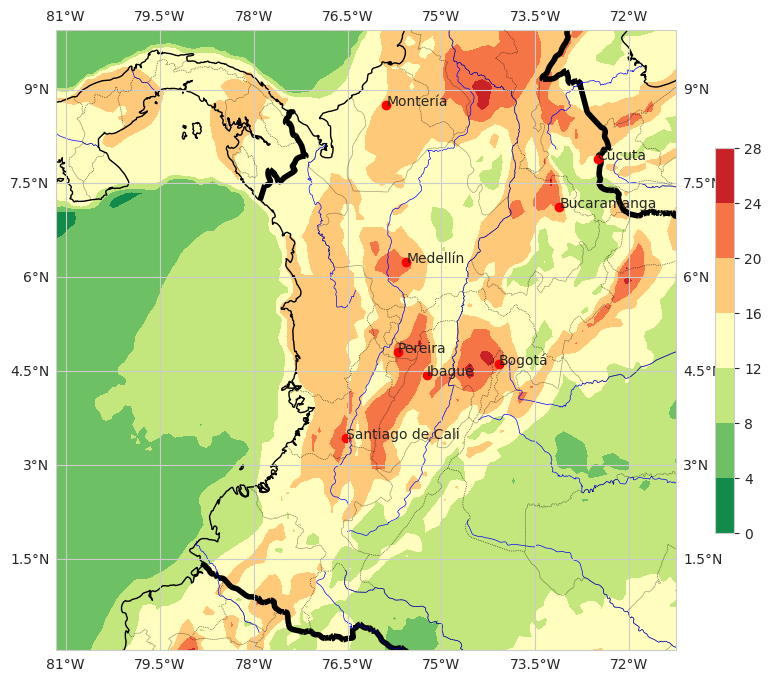

In [ ]:
plot_map(data=pm25, lat=lat, lon=lon, cities=cities, colormap='RdYlGn_r')

# Functions

# Files

In [ ]:
"""
Annual and monthly datasets are provided in NetCDF [.nc] format, with naming
convention V6GL02.02.CNNPM25.REGION.YYYYMM_START-YYYYMM_END.nc. REGION refers
to the file region (e.g. ‘Global’). YYYYMM_START and YYYYMM_END refer to the
numeric start and end date of the file (e.g. for annual mean PM2.5 for 2015,
YYYYMM_START is 201501 and YYYYMM_END is 201512). Gridded files use the WGS84
projection.

Variable names within these files include:

‘lat’: Latitude coordinate centers of the PM2.5 grid
‘lon’: Longitude coordinates centers of the PM2.5 grid
‘PM25’: Gridded mean PM2.5 concentrations

Using 0.1 by 0.1 lat and lon
https://www.johndcook.com/how_big_is_a_degree.html
A degree of latitude, one degree north or south, is about the same distance
anywhere, about 69 miles (111 kilometers). But a degree of longitude, one
degree east or west, is a different distance at different points on the globe.
At the equator, a degree of longitude is the same as a degree of latitude,
about 69 miles (111 km). But it decreases as you move closer to the north or
south pole

~ roughly 11k by 11k
"""
path_folder = '/content/drive/MyDrive/propane/data_pm25'
files = np.sort([path_folder + '/' + file for file in os.listdir(path_folder)])
files
dates = [
    datetime.datetime.strptime(re.findall(r"(\d\d\d\d\d\d).nc", file)[0], "%Y%m")
    for file in files
]

print(f"len(files): {len(files):}")
print(f"len(dates): {len(dates)}")
files[0]

len(files): 96
len(dates): 96


'/content/drive/MyDrive/propane/data_pm25/V6GL02.02.0p10.CNNPM25.GL.201501-201501.nc'

In [ ]:
pm25, lat, lon = get_data(path=files[0], lat_ndvi=lat_ndvi, lon_ndvi=lon_ndvi)
# pm25 = pm25[:, :, np.newaxis, np.newaxis, np.newaxis]
print(f"pm25.shape: {pm25.shape}")

pm25.shape: (100, 100)


In [ ]:
# shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
storage = pm25[:, :, np.newaxis, np.newaxis, np.newaxis]
for path in tqdm(files[1:]):
    pm25, _, _ = get_data(path=path, lat_ndvi=lat_ndvi, lon_ndvi=lon_ndvi)
    storage = np.concatenate((storage, pm25[:, :, np.newaxis, np.newaxis, np.newaxis]), axis=2)
print(f"storage.shape: {storage.shape}")

# save
path = '/content/drive/MyDrive/propane/data_agg/pm25.pickle'
with open(path, 'wb') as f:
    pickle.dump(storage, f)

path = '/content/drive/MyDrive/propane/data_agg/lat_pm25.pickle'
with open(path, 'wb') as f:
    pickle.dump(lat, f)

path = '/content/drive/MyDrive/propane/data_agg/lon_pm25.pickle'
with open(path, 'wb') as f:
    pickle.dump(lon, f)

# save
path = '/content/drive/MyDrive/propane/data_agg/dates_pm25.pickle'
with open(path, 'wb') as f:
    pickle.dump(dates, f)


100%|██████████| 95/95 [02:59<00:00,  1.89s/it]


storage.shape: (100, 100, 96, 1, 1)


In [ ]:
# save
path = '/content/drive/MyDrive/propane/data_agg/dates_pm25.pickle'
with open(path, 'wb') as f:
    pickle.dump(np.array(dates), f)

In [ ]:
with open(path, 'rb') as f:
    dates = pickle.load(f)
print(f"dates.min(): {dates.min()}, dates.max(): {dates.max()}")

dates.min(): 2015-01-01 00:00:00, dates.max(): 2022-12-01 00:00:00
